<a href="https://colab.research.google.com/github/behaapyy/Bioinformatics-with-Python-Cookbook-Second-Edition/blob/master/CookBook_CH4(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Bio.PopGen으로 데이터셋 탐색하기**:

In [5]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

from Bio.PopGen.GenePop import Controller as gpc

%matplotlib inline

**Genepop을 실행해 유전형의 빈도를 계산**

- genepop? population genetics software package
- 이 장에서는 Biopython이 제공하는 인터페이스를 사용해서 genepop을 실행
- 계산이 오래 걸리므로 유전형빈도를 집단과 로커스별로 나누어 계산하도록 - ctrl 변수의 이터레이터를 이용한다
  - 로커스: 특정 유전자나 유전 표지자가 위치한 염색체상의 특이적이고 고정된 위치

In [ ]:
ctrl = gpc.GenePopController()
my_pops = [l.rstrip() for l in open('hapmap10_auto_noofs_2.pops')]
num_pops = len(my_pops)
pop_iter, loci_iter = ctrl.calc_allele_genotype_freqs('hapmap10_auto_noofs_2.gp')

**모든 로커스의 고정된 대립 유전자와 최소 대립 유전자 빈도에 대한 통계와 검색 정보 알아보기**
- 3가지의 데이터 구조 생성 :
  - 각 집단의 단일형 로커스의 수를 세는 것
  - 집단과 로커스당 리드 수를 세는 것
  - 각 집단의 최소 대립 유전자의 빈도를 저장하는 것 

In [ ]:
num_pops = len(my_pops)
fix_pops = [0 for i in range(num_pops)]
num_reads = [defaultdict(int) for i in range(num_pops)]
num_buckets = 20
MAFs = []
for i in range(num_pops):
    MAFs.append([0] * num_buckets)
for locus_data in loci_iter:
    locus_name = locus_data[0]
    allele_list = locus_data[1]
    pop_of_loci = locus_data[2]
    for i in range(num_pops):
        locus_num_reads = pop_of_loci[i][2]
        num_reads[i][locus_num_reads] += 1
        maf = min(pop_of_loci[i][1])
        if maf == 0:
            fix_pops[i] += 1
        else:
            bucket = min([num_buckets - 1, int(maf * 2 * num_buckets)])
            MAFs[i][bucket] += 1

**결과를 시각화**
- 가장 위 그래프: 집단별 단일형 대립 유전자의 수
- 두번째 그래프: 로커스별 대립 유전자 리드의 최댓값
- 마지막: MAF 값의 분포를 세 가지 집단의 경우에서 살펴본 것
  - MAF: Minor Allele Frequency, 주어진 집단에서 두 번째로 흔한 대립 유전자 표현형의 빈도, 샘플링의 영향을 받음
  - 집단의 크기가 작으면 MAF 값의 변동이 크고 집단이 크면 MAF 값의 변동이 작음

In [ ]:
fig, axs = plt.subplots(3, figsize=(16, 9), squeeze=False)
axs[0, 0].bar(range(num_pops), fix_pops)
axs[0, 0].set_xlim(0, 11)
axs[0, 0].set_xticks(0.5 + np.arange(num_pops))
axs[0, 0].set_xticklabels(my_pops)
axs[0, 0].set_title('Monomorphic positions')

axs[1, 0].bar(range(num_pops), [np.max(list(vals.keys())) for vals in num_reads])
axs[1, 0].set_xlim(0, 11)
axs[1, 0].set_xticks(0.5 + np.arange(num_pops))
axs[1, 0].set_xticklabels(my_pops)
axs[1, 0].set_title('Maximum number of allele reads per loci')

for pop in [0, 7, 8]:
    axs[2, 0].plot(MAFs[pop], label=my_pops[pop])
axs[2, 0].legend()
axs[2, 0].set_xticks(range(num_buckets + 1))
axs[2, 0].set_xticklabels(['%.3f' % (x / (num_buckets * 2.)) for x in range(num_buckets + 1)])
axs[2, 0].set_title('MAF bundled in bins of 0.025')
None

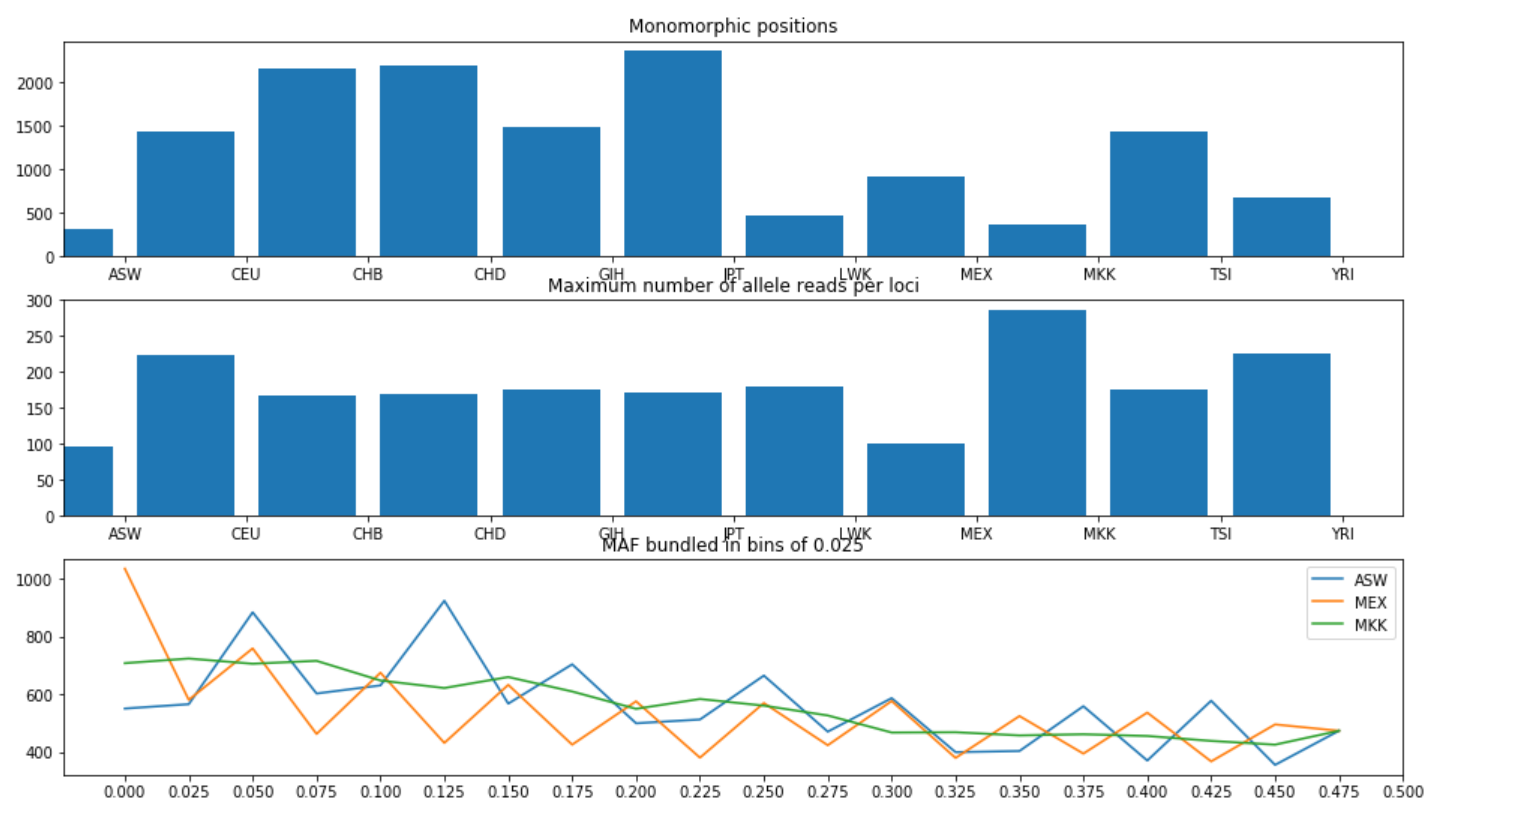

- 각 집단별로 예상되는 이형접합체의 수를 계산,
- 집단 정보를 이터레이터로 순회하며 집단의 이름, 로커스 정보, 예상되는 동형접합체의 수를 추출

In [7]:
#for pop_data in pop_iter:
#    pop_name, allele = pop_data
#    print(pop_name)
#    for locus_name, vals in allele.items():
#        geno_list, heterozygosity, allele_cnts, summary = vals
#        print(locus_name, vals)
#        break
#    break

In [ ]:
exp_hes = []
for pop_data in pop_iter:
    pop_name, allele = pop_data
    print(pop_name)
    exp_vals = []
    for locus_name, vals in allele.items():
        geno_list, heterozygosity, allele_cnts, summary = vals
        cexp_ho, cobs_ho, cexp_he, cobs_he = heterozygosity
        exp_vals.append(cexp_he / (cexp_he + cexp_ho))
    exp_hes.append(exp_vals)

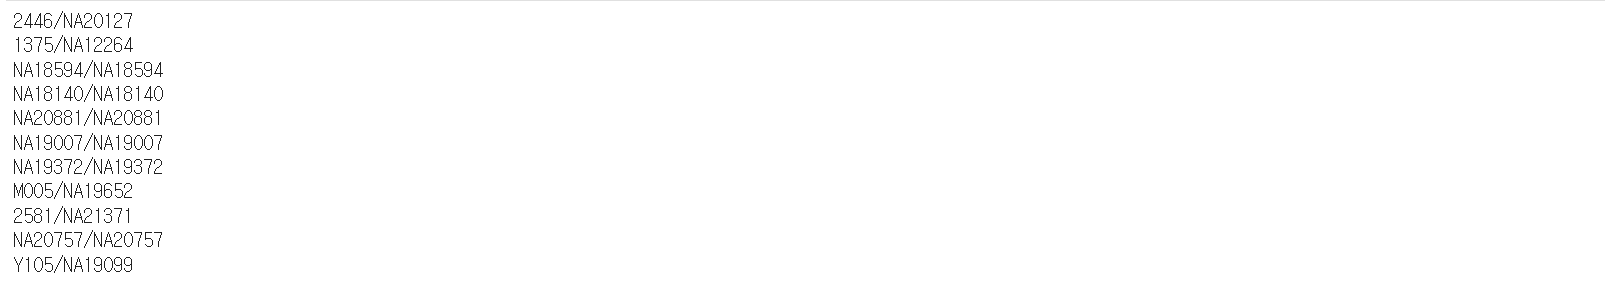

**집단별 이형접합체의 분포를 시각화**

In [ ]:
#XXX correct this
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
bplot = ax.boxplot(exp_hes, notch=True, patch_artist=True)
#print(bplot.keys())
#bplot['boxes'][0].set_facecolor('red')
#bplot['boxes'][0].set_edgecolor('red')
ax.set_title('Distribution of expected Heterozygosity')
ax.set_xticks(1 + np.arange(num_pops))
ax.set_xticklabels(my_pops)
None

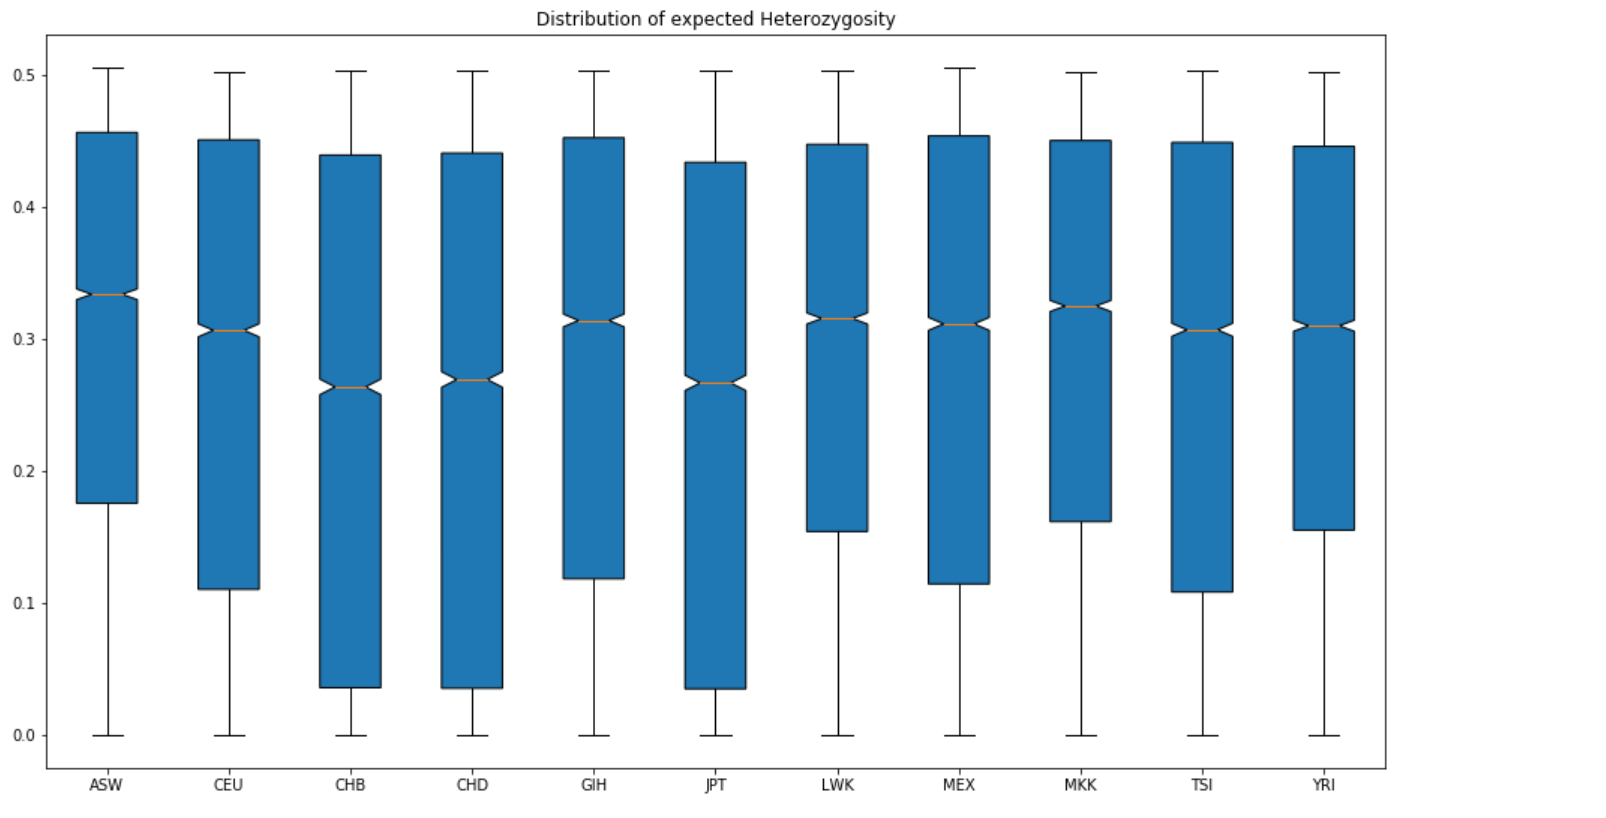

### **F-통계 계산하기**

F-통계란? 
- 일정 수준의 하위 집단에서 근친 교배 효과를 정량화하기 위한 수단
- 이후 유전학적 통계에서 가장 널리 사용되며 집단 구조에 의해 발생되는 유전적 변이를 효과적으로 표현하는 것으로 알려짐

- 통계학에서 F값(F ratio)은 F 분포(F distribution)에서 사용되는 연속 확률 분포의 값, 비율 분포라고 볼 수 있음
- F = 샘플간 평균 분산/ 샘플내 분산

In [9]:
from collections import defaultdict

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from Bio.PopGen.GenePop import Controller as gpc
%matplotlib inline

**데이터셋의 총 11개의 집단에 대한 F-통계를 계산**
- 로커스별 F-통곗값들을 가진 이터레이터를 반환
- 모든 이터레이터를 순회하는 것은 계산이 오래 걸리므로 실무에서는 큰 MAF 값을 가지는 로커스만 사용

In [ ]:
my_pops = [l.rstrip() for l in open('hapmap10_auto_noofs_2.pops')]
num_pops = len(my_pops)

In [ ]:
ctrl = gpc.GenePopController()

In [ ]:
(multi_fis, multi_fst, multi_fit), f_iter = ctrl.calc_fst_all('hapmap10_auto_noofs_2.gp')

In [ ]:
print(multi_fis, multi_fst, multi_fit)

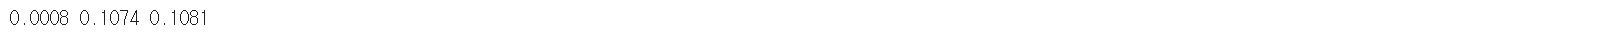

**모든 로커스의 결과를 배열 데이터로 만들고 분포의 요약을 시각화**

In [ ]:
fst_vals = []
fis_vals = []
fit_vals = []
for f_case in f_iter:
    name, fis, fst, fit, qinter, qintra = f_case
    fst_vals.append(fst)
    fis_vals.append(fis)
    fit_vals.append(fit)

In [ ]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1)
ax.hist(fst_vals, 50, color='r')
ax.set_title('FST, FIS and FIT distributions')
ax.set_xlabel('FST')
ax = fig.add_subplot(2, 3, 2)
sns.violinplot([fis_vals], ax=ax, vert=False)
ax.set_yticklabels(['FIS'])
ax.set_xlim(-.15, 0.4)
ax = fig.add_subplot(2, 3, 3)
sns.violinplot([fit_vals], ax=ax, vert=False)
ax.set_yticklabels(['FIT'])
ax.set_xlim(-.15, 0.4)

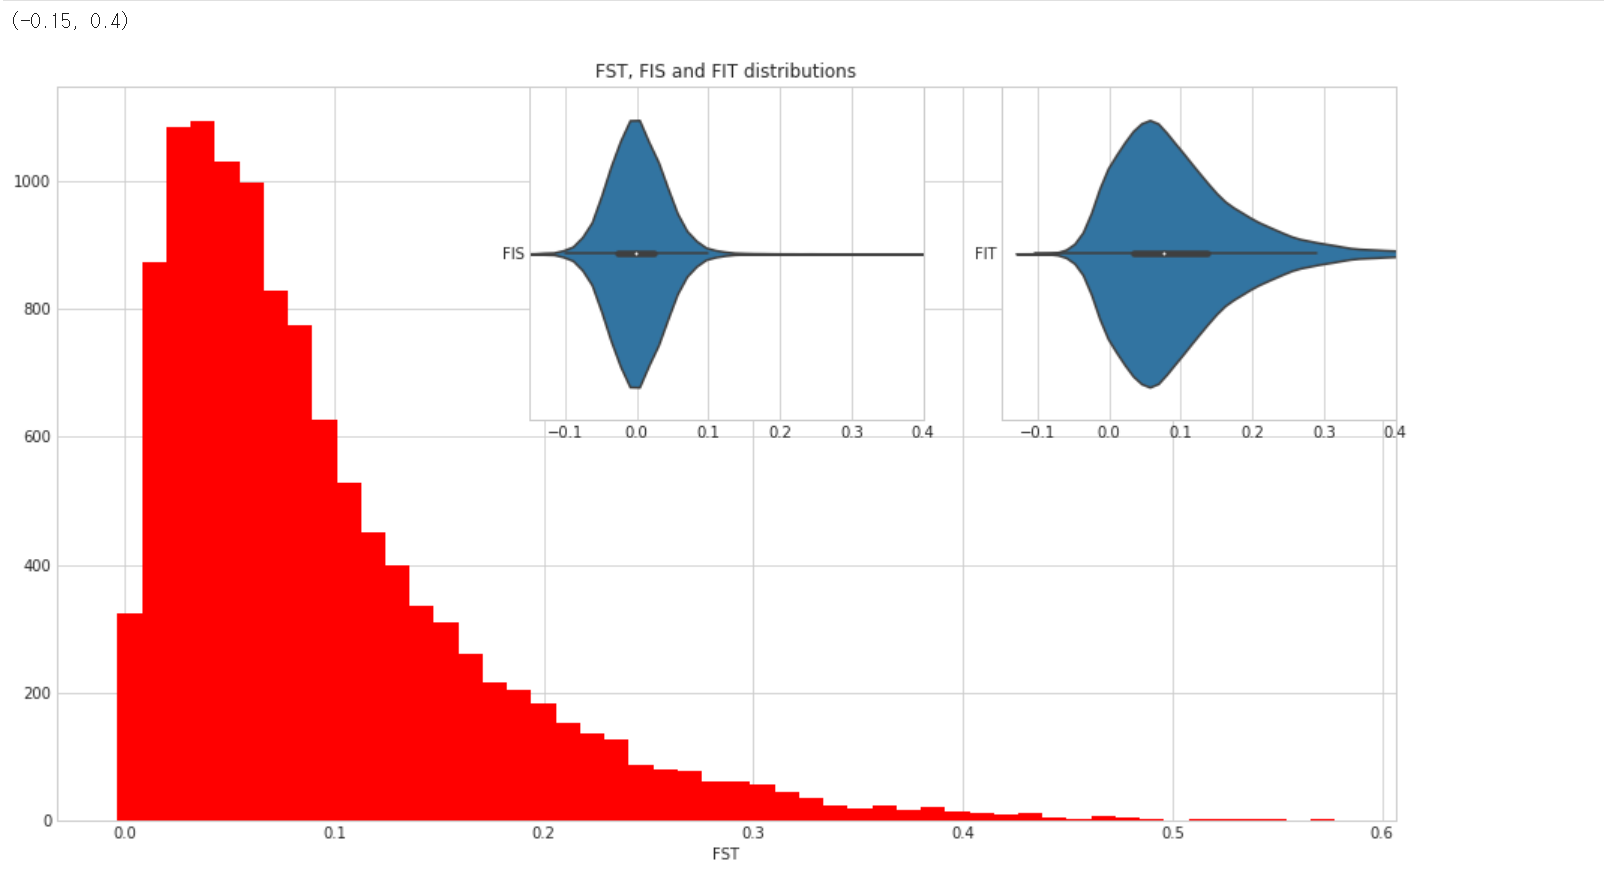

- FIT: the correlation between gametes that unite to produce the
individuals, relative to the gametes of the total population.
- FIS: the average overall subdivisions of the correlation
between uniting gametes relative to those of their subdivision. 
- FST is the correlation between random gametes within subdivisions, relative to gametes of the total population. 
  - FIT = FIS+(1-FIS)*FST


**모든 집단을 쌍으로 묶어 평균 FST를 계산**
- 여기서는 FST 값의 평균이 들어있는 avg 변수를 사용
- FST 값을 이용해 집단 간 열 지도(heat map, cell의 색을 분화의 정도로 나타낸 것으로 각각의 셀은 두 집단 간의 평균 FST 값)을 그림

In [ ]:
fpair_iter, avg = ctrl.calc_fst_pair('hapmap10_auto_noofs_2.gp')

In [ ]:
min_pair = min(avg.values())
max_pair = max(avg.values())
arr = np.ones((num_pops - 1, num_pops - 1, 3), dtype=float)

In [ ]:
sns.set_style("white")
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for row in range(num_pops - 1):
    for col in range(row + 1, num_pops):
        val = avg[(col, row)]
        norm_val = (val - min_pair) / (max_pair - min_pair)
        ax.text(col - 1, row, '%.3f' % val, ha='center')
        if norm_val == 0.0:
            arr[row, col - 1, 0] = 1
            arr[row, col - 1, 1] = 1
            arr[row, col - 1, 2] = 0
        elif norm_val == 1.0:
            arr[row, col - 1, 0] = 1
            arr[row, col - 1, 1] = 0
            arr[row, col - 1, 2] = 1
        else:
            arr[row, col - 1, 0] = 1 - norm_val
            arr[row, col - 1, 1] = 1
            arr[row, col - 1, 2] = 1
ax.imshow(arr, interpolation='none')
ax.set_title('Multilocus Pairwise FST')
ax.set_xticks(range(num_pops - 1))
ax.set_xticklabels(my_pops[1:])
ax.set_yticks(range(num_pops - 1))
ax.set_yticklabels(my_pops[:-1])

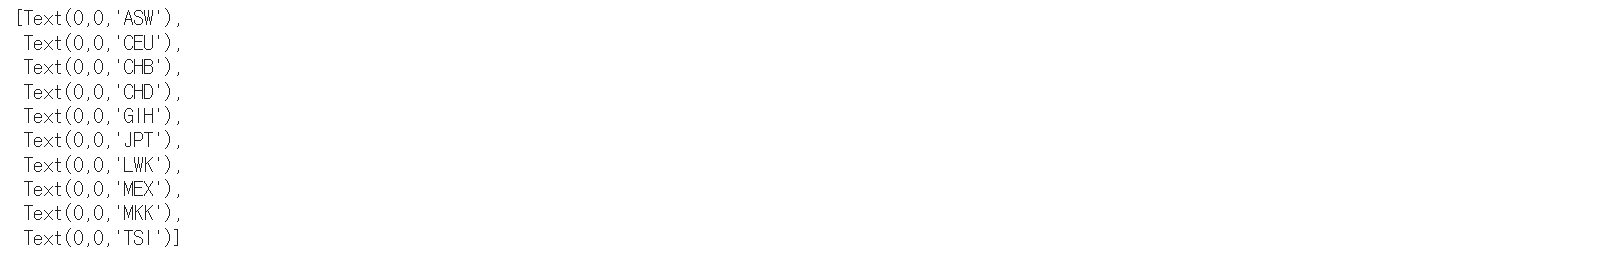

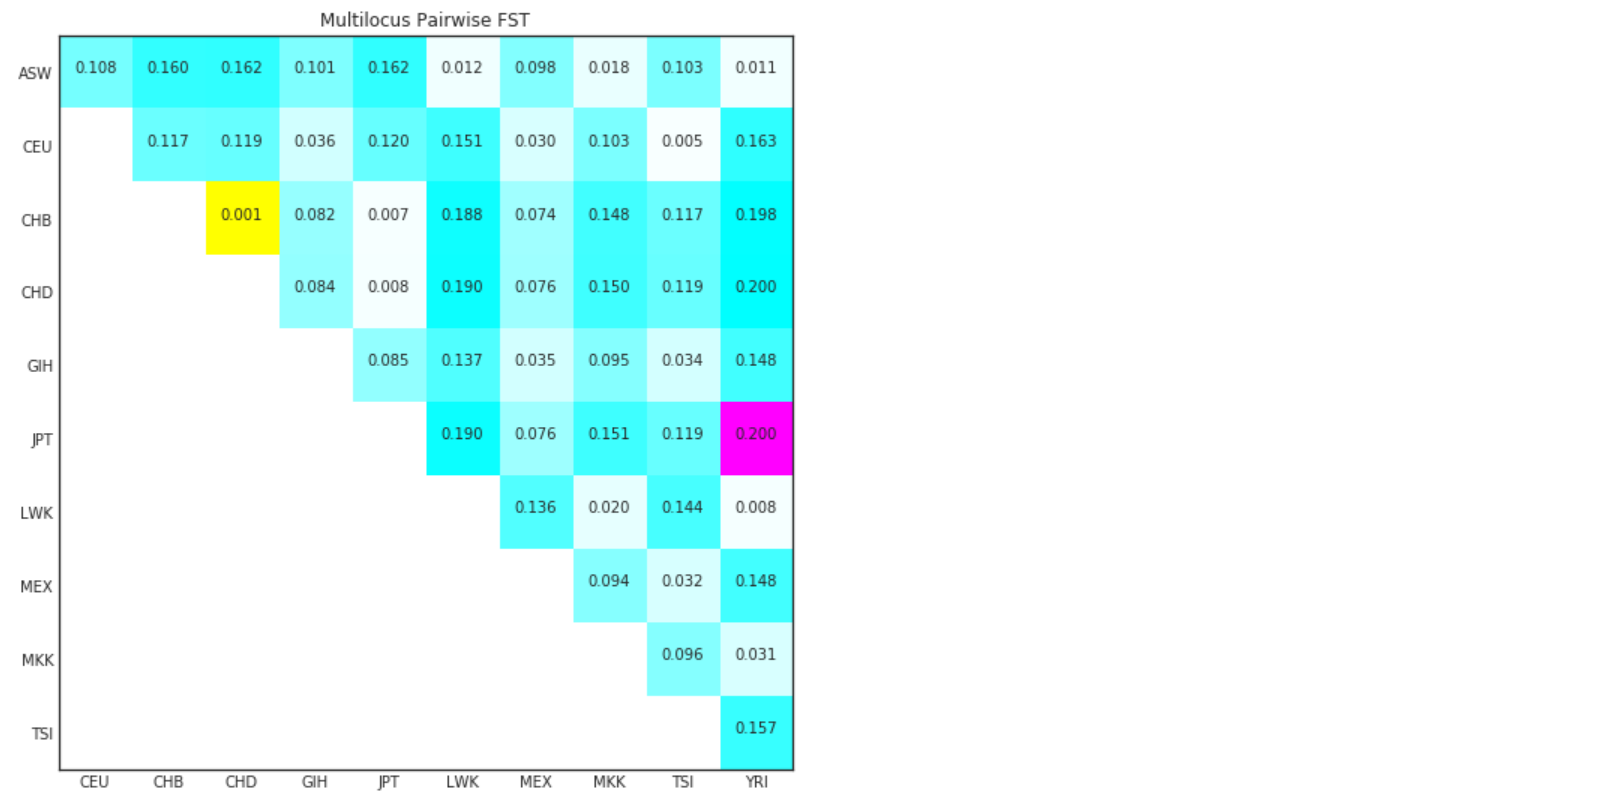

**2번 염색체에 있는 LCT 유전자 주변 서열을 가지고 요루바족, 북유럽 간의 FST 값을 계산**

In [ ]:
pop_ceu = my_pops.index('CEU')
pop_yri = my_pops.index('YRI')
start_pos = 136261886  # b36
end_pos = 136350481
all_fsts = []
inside_fsts = []
for locus_pfst in fpair_iter:
    name = locus_pfst[0]
    pfst = locus_pfst[1]
    pos = int(name.split('/')[-1])  # dependent
    my_fst = pfst[(pop_yri, pop_ceu)]
    if my_fst == '-':  # Can be this
        continue
    all_fsts.append(my_fst)
    if pos >= start_pos and pos <= end_pos:
        inside_fsts.append(my_fst)

In [ ]:
print(inside_fsts)
print('%.2f/%.2f/%.2f' % (np.median(all_fsts), np.mean(all_fsts), np.percentile(all_fsts, 90)))

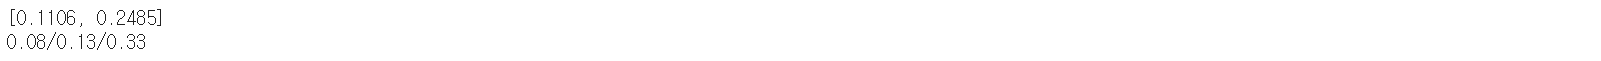

위 출력 결과의 첫 줄은 LCT 유전자 주변 서열의 집단 간 FST값, 두 번째 줄은 전체 염색체의 FST값에 대한 median, mean, 90% 값

일반적으로 LCT 유전자 주변 서열의 FST 값 > 전체 염색체 서열의 FST 값

그 이유는 LCT 유전자가 CEU 집단에서 진화적으로 선택되었기 때문, 
즉 FST 값을 통해 특정 유전자 선호도를 통계적 정보로 나타낼 수 있는 것


= 이를 이용하면 단일 염기 변이 (point mutation)에 관한 선호도를 알 수 있음



In [ ]:
100 * (end_pos - start_pos) / 242000000.0

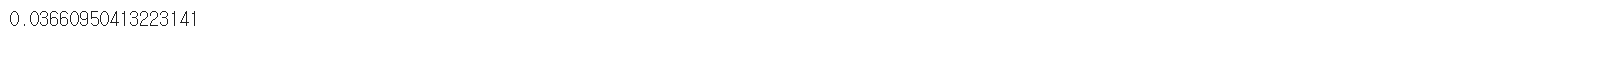